<a href="https://colab.research.google.com/github/ronniegertman/harmonic-oscillator/blob/two_oscillators/two_oscillators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#dependencies
import numpy as np
import scipy
import scipy.fft as fft
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress as linreg
from scipy.optimize import curve_fit as cfit
from sklearn.metrics import r2_score
from scipy.signal import find_peaks
import scipy.ndimage as ndimage
from prettytable import PrettyTable as prtable


In [ ]:
#first exp
cart1 = 206.48 / 1000 #kg
cart2 = 205.85 / 1000 #kg
lines = 241
length = (72.4 - 60)/100 #m
counts_to_meter = length/lines #m

dl = 97.95 #mm
k1 = 42.57/dl * 9.8
k2 = 43.7/dl * 9.8
k3 = 43/dl * 9.8


weight_err = 0.01 / 1000 #kg


In [ ]:
#second exp
#all weights were added to cart b
pull_mass = 4.75
weights_array = cart2 + np.array([pull_mass, 13.92, 23.04, 24.04, 32.29, 33.81])/1000
files = ["just_stick.csv", "2light.csv","4light.csv", "2mid.csv",
         "6light.csv", "2heavy.csv"]




In [ ]:
def cos(t, A, w, phi, b):
  return A * np.cos(w*t + phi) + b

def cos2(t, A, B, w1, w2, phi1, phi2, b1):
  return A* np.cos(w1*t + phi1) + B * np.cos(w2*t + phi2) + b1

In [ ]:
def calc_varience(amplitudes):
  return np.var(amplitudes[10:25])

In [ ]:
def calc_freq_fourier(time, x_cart1, x_cart2):
  dt = time[1] - time[0]
  fs = 1 / dt

  fft_result = np.fft.fft(x_cart1)
  frequencies = np.fft.fftfreq(len(x_cart1), dt)

  positive_frequencies = frequencies[frequencies >= 0]
  positive_amplitude = np.abs(fft_result[frequencies >= 0])

  plt.figure(figsize=(10,6))
  plt.plot(positive_frequencies[1:50], positive_amplitude[1:50], label="FFT cart1")
  plt.title("Fourier transform")
  plt.xlabel("Frequency [Hz]")
  plt.ylabel("Amplitude [m]")
  plt.grid()


  fft_result = np.fft.fft(x_cart2)
  frequencies = np.fft.fftfreq(len(x_cart2), dt)

  positive_frequencies = frequencies[frequencies >= 0]
  positive_amplitude = np.abs(fft_result[frequencies >= 0])
  plt.plot(positive_frequencies[1:50], positive_amplitude[1:50], label="FFT cart2")

  plt.legend()

  var = calc_varience(positive_amplitude)
  print("width is ", np.sqrt(var)/2)

  delta_omega_index = np.argmax(positive_amplitude) #finding the highest amplitude
  return 2*np.pi*positive_frequencies[delta_omega_index] #returning the corresponding freq


In [ ]:
#exp 1

#first eigen mode
eigen1 = pd.read_csv("eigen1.csv")
time_eigen1 = eigen1['time(s)'].values
cart1_eigen1 = eigen1['count B'].values * counts_to_meter
cart2_eigen1 = eigen1['count A'].values * counts_to_meter

#second eigen mode
eigen2 = pd.read_csv("eigen2.csv")
time_eigen2 = eigen2['time(s)'].values
cart1_eigen2 = eigen2['count B'].values * counts_to_meter
cart2_eigen2 = eigen2['count A'].values * counts_to_meter

#random mode
random = pd.read_csv("random.csv")
time_random = random['time(s)'].values
cart1_random = random['count B'].values * counts_to_meter
cart2_random = random['count A'].values * counts_to_meter

plt.figure()
plt.plot(time_eigen1, cart1_eigen1,'.', label="cart1")
plt.plot(time_eigen1, cart2_eigen1,'.', label="cart2")
plt.legend()
plt.title("First Eigen Mode")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()

plt.figure()
plt.plot(time_eigen2, cart1_eigen2, '.', label="cart1")
plt.plot(time_eigen2, cart2_eigen2, '.', label="cart2")
plt.legend()
plt.title("Second Eigen Mode")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()

plt.figure()
plt.plot(time_random, cart1_random, '.', label="cart1")
plt.plot(time_random, cart2_random, '.', label="cart2")
plt.legend()
plt.title("Random Mode")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()


In [ ]:
def compute_omega(k1, k2, k3, m1, m2):
    # Compute the discriminant (Delta)
    delta = (
        k1**2 * m2**2
        - 2 * k1 * k2 * m1 * m2
        + 2 * k1 * k2 * m2**2
        - 2 * k1 * k3 * m1 * m2
        + k2**2 * m1**2
        + 2 * k2**2 * m1 * m2
        + k2**2 * m2**2
        + 2 * k2 * k3 * m1**2
        - 2 * k2 * k3 * m1 * m2
        + k3**2 * m1**2
    )

    # Compute the terms inside the square roots
    term1 = k1 * m2 + k2 * m1 + k2 * m2 + k3 * m1

    # Compute the eigenfrequencies
    omega1 = np.sqrt(2) * np.sqrt(term1 - np.sqrt(delta)) / (2 * np.sqrt(m1) * np.sqrt(m2))
    omega2 = np.sqrt(2) * np.sqrt(term1 + np.sqrt(delta)) / (2 * np.sqrt(m1) * np.sqrt(m2))

    return omega1, omega2

width is  0.18165678633353638
4.39822971502571
width is  1.3848791440001798
7.539822368615504
width is  0.6767641949346997


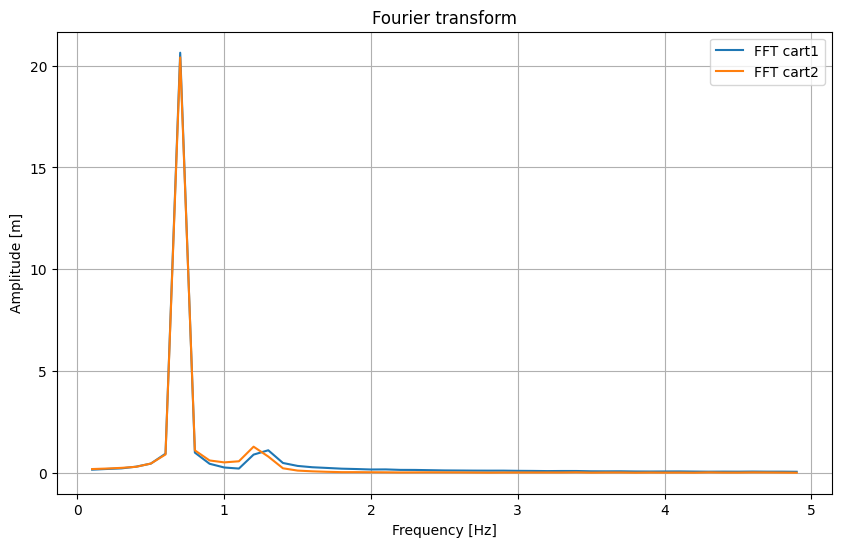

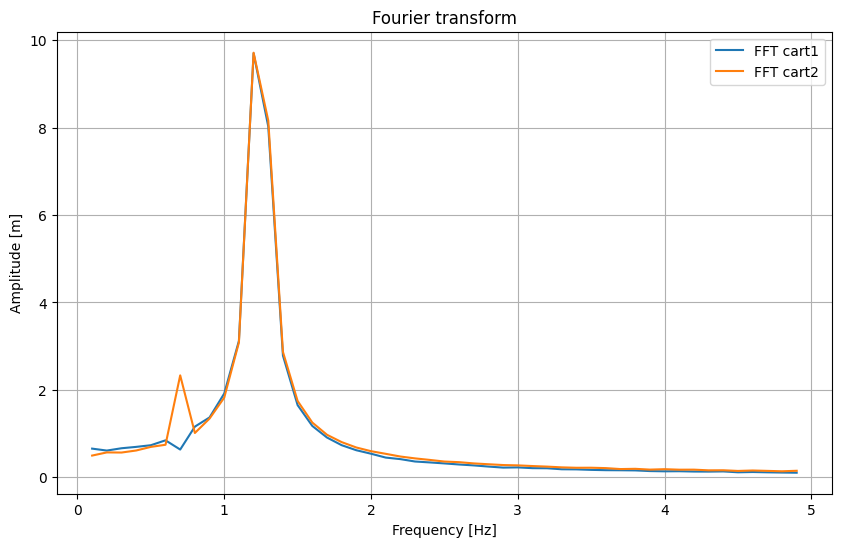

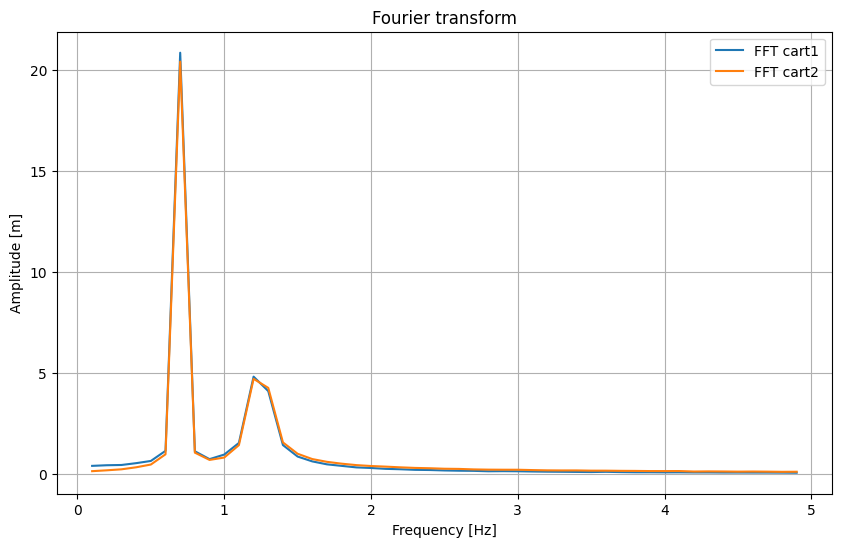

In [ ]:
w1_eigen = calc_freq_fourier(time_eigen1, cart1_eigen1, cart2_eigen1)
print(w1_eigen)

w2_eigen = calc_freq_fourier(time_eigen2, cart1_eigen2, cart2_eigen2)
print(w2_eigen)

fourier_trans = calc_freq_fourier(time_random, cart1_random, cart2_random)


In [ ]:
#calculating cfit of superposition
#po = ([t, A, B, w1, w2, phi1, phi2, b1])
[w1, w2] = compute_omega(k1, k2, k3, cart1, cart2)
p0 = ([1, 0.025, 1, w1_eigen, w2_eigen, 0, 0, 0])
params,cov = cfit(cos2, time_random, cart2_random, p0=p0)

w1_fit, w2_fit = params[3], params[4]
print(w1_fit, w2_fit)
A_fit = params[0]
B_fit = params[1]
print(A_fit, B_fit)
phi1_fit = params[5]
phi2_fit = params[6]
b1_fit = params[7]

plt.figure()
plt.plot(time_random, cart2_random, 'b.', label="cart1")
cos2_vec = cos2(time_random, *params)
plt.plot(time_random, cos2_vec, 'r.', label="fit")
plt.legend()
plt.grid()


In [ ]:
#graph of avg between 2 carts (w1a, w2a) as a function of mass
def w1_w2(omega, amp):
  data = np.vstack((amp, omega)).T

  # Sort the data by amplitude in descending order
  sorted_data = data[data[:, 0].argsort()[::-1]]  # Sort by the first column (amp)

  # Extract the second-largest amplitude and corresponding omega
  largest_amp = sorted_data[0, 0]
  corresponding_omega_largest = sorted_data[0, 1]

  second_largest_amp = sorted_data[1, 0]
  corresponding_omega_second = sorted_data[1, 1]
  return corresponding_omega_largest, corresponding_omega_second

In [ ]:
def calc_freq_fourier_simple(time, x):
  dt = time[1] - time[0]
  fs = 1 / dt

  fft_result = np.fft.fft(x)
  frequencies = np.fft.fftfreq(len(x), dt)

  positive_frequencies = frequencies[frequencies >= 0]
  positive_amplitude = np.abs(fft_result[frequencies >= 0])

  var = calc_varience(positive_amplitude)
  print("width is ", np.sqrt(var)/2)

  w1, w2 = w1_w2(positive_frequencies, positive_amplitude) #the two eigenmodes

  return 2*np.pi*(w1), 2*np.pi*(w2), var


In [ ]:
def w1_w2_avg(time, x_cart1, x_cart2):
  w1_cart1, w2_cart1, var1 = calc_freq_fourier_simple(time, x_cart1)
  w1_cart2, w2_cart2, var2 = calc_freq_fourier_simple(time, x_cart2)
  return (w1_cart1 + w1_cart2)/2, (w2_cart1 + w2_cart2)/2

In [72]:
def calc_freq_simple(dt, Nperiods):
  return 2*np.pi*Nperiods/dt

In [73]:
calc_freq_simple(3, 2)


4.1887902047863905

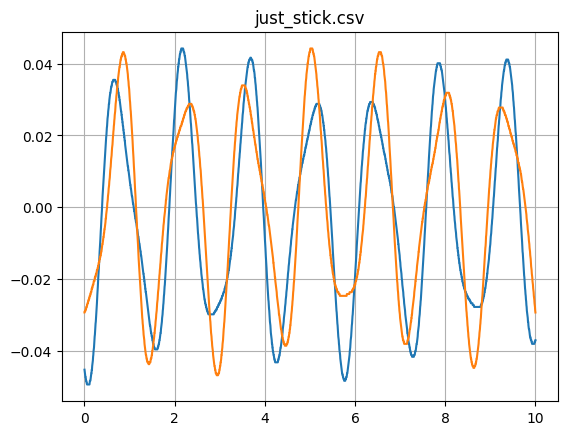

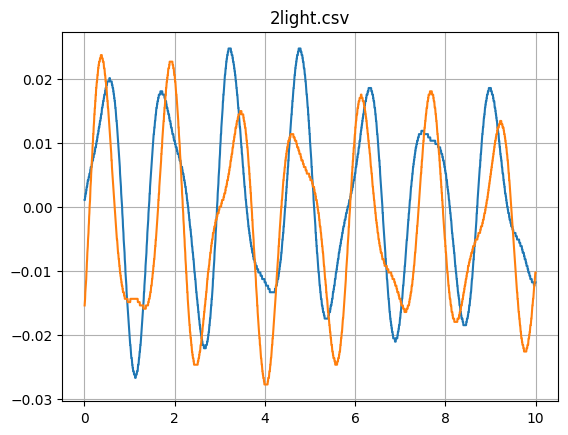

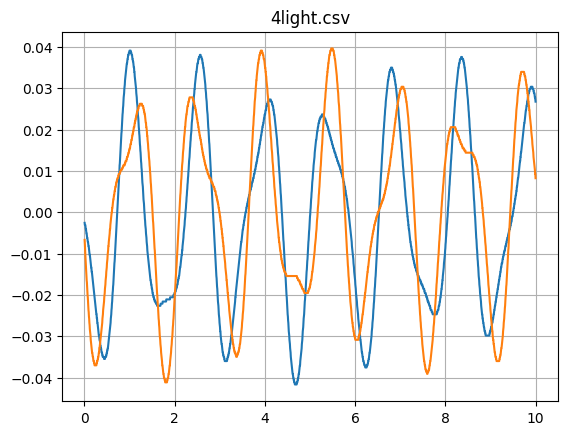

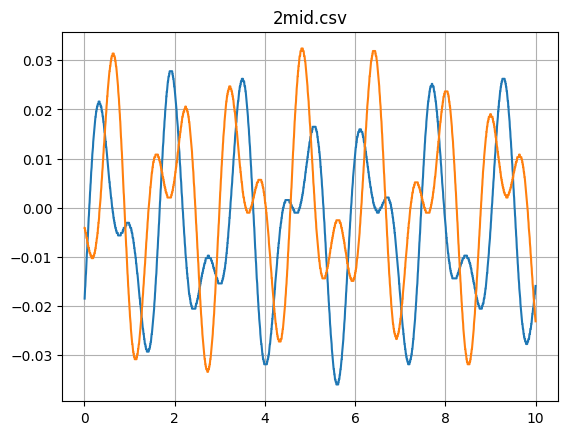

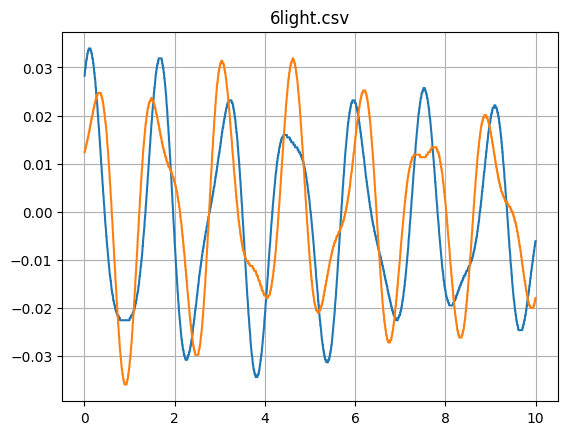

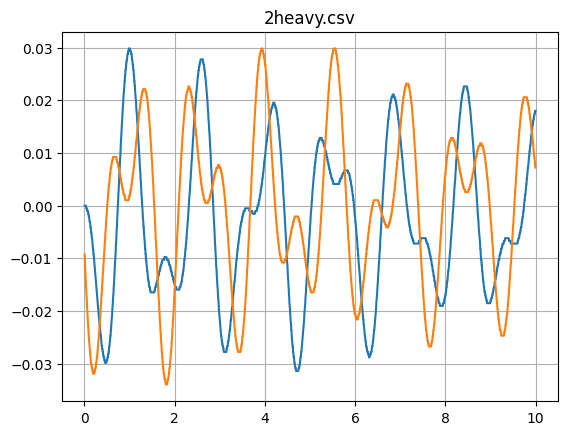

In [ ]:
def analyze_data(files_array, weights_array):
  w1_array = []
  w2_array = []
  for file in files_array:
    data = pd.read_csv(file)
    time = data['time(s)'].values
    x_cart1 = data['count B'].values * counts_to_meter
    x_cart2 = data['count A'].values * counts_to_meter
    plt.figure()
    plt.plot(time, x_cart1, label="cart1")
    plt.plot(time, x_cart2, label="cart2")
    plt.grid()
    plt.title(file)
  #   w1, w2 = w1_w2_avg(time, x_cart1, x_cart2)
  #   w1_array.append(w1)
  #   w2_array.append(w2)

  # plt.figure(figsize=(10,6))
  # plt.plot(weights_array, w1_array,'.', label="first eigenmode")
  # plt.plot(weights_array, w2_array,'.', label="second eigenmode")
  # plt.title("Eigenmodes")
  # plt.xlabel("Mass (kg)")
  # plt.ylabel("Frequency (rad/sec)")
  # plt.legend()

analyze_data(files, weights_array)

In [ ]:
def better_fourier(time, x_cart1, x_cart2):
  X = fft.fft(x_cart1)  # FFT of signal x
  frequencies = fft.fftfreq(len(time), d=(time[1] - time[0]))  # Frequency bins
  positive_freq_idx = np.where(frequencies >= 0)  # Indices of positive frequencies
  frequencies = frequencies[positive_freq_idx]
  amplitudes = np.abs(X[positive_freq_idx]) / len(time)  # Normalize amplitudes

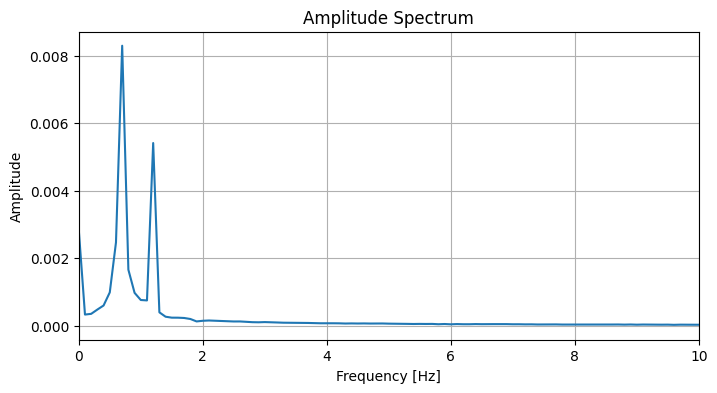

0.7000000000000001


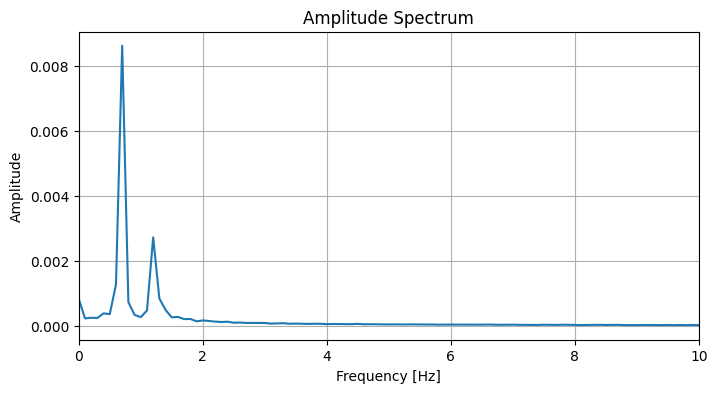

0.7000000000000001


In [ ]:
data = pd.read_csv("2heavy.csv")
time = data['time(s)'].values
x_cart1 = data['count B'].values * counts_to_meter
x_cart2 = data['count A'].values * counts_to_meter
X = fft.fft(x_cart1, n=len(time))  # FFT of signal x
frequencies = fft.fftfreq(len(time), d=(time[1] - time[0]))  # Frequency bins
positive_freq_idx = np.where(frequencies >= 0)  # Indices of positive frequencies
frequencies = frequencies[positive_freq_idx]
amplitudes = np.abs(X[positive_freq_idx]) / len(time)  # Normalize amplitudes

# Plot the FFT result
plt.figure(figsize=(8, 4))
plt.plot(frequencies, amplitudes)
plt.title("Amplitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 10)
plt.grid()
plt.show()
print(frequencies[np.argmax(amplitudes)])


data = pd.read_csv("2light.csv")
time = data['time(s)'].values
x_cart1 = data['count B'].values * counts_to_meter
x_cart2 = data['count A'].values * counts_to_meter
X = fft.fft(x_cart1, n=len(time))  # FFT of signal x
frequencies = fft.fftfreq(len(time), d=(time[1] - time[0]))  # Frequency bins
positive_freq_idx = np.where(frequencies >= 0)  # Indices of positive frequencies
frequencies = frequencies[positive_freq_idx]
amplitudes = np.abs(X[positive_freq_idx]) / len(time)  # Normalize amplitudes

# Plot the FFT result
plt.figure(figsize=(8, 4))
plt.plot(frequencies, amplitudes)
plt.title("Amplitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 10)
plt.grid()
plt.show()
print(frequencies[np.argmax(amplitudes)])

